# Analyzing classification result

In [194]:
import logging
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mne.decoding import CSP

mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

In [195]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [196]:
import conf
import utils
import transforms as trans

## Building and running the best pipeline (`csp_svm`)

Next, we run the best pipeline once which we have developed which provided 85.3%
accuracy previously.

In [197]:
# Load our dataset
with (conf.DATA_DIR / "filteredX.pickle").open("rb") as f:
  filteredX = pickle.load(f)
  
with (conf.DATA_DIR / "y.npy").open("rb") as f:
  y = pickle.load(f)

In [198]:
best_start = conf.dT - 0.1

window_length = 0.3

clf = make_pipeline(
  trans.GetWindow(best_start, best_start + window_length),
  trans.NpArrayTransform,
  CSP(),
  SVC(gamma='auto'),
)

In [200]:
clf.fit(filteredX, y); pass

In [201]:
y_hat = clf.predict(filteredX)

## Obtaining GWOSC Parameter Estimations for detected coalescenses

In [208]:
# Get the GWOSC catalog containing estimated parameters

confident = pd.read_csv("https://www.gw-openscience.org/eventapi/csv/allevents/")

In [209]:
confident.loc[:2]

,id,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,...,redshift_upper,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,151008-v1,151008,1,GWTC-1-marginal,1.128349e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,NaN,NaN,NaN,...,NaN,10.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,151012.2-v1,151012.2,1,GWTC-1-marginal,1.128667e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,NaN,NaN,NaN,...,NaN,8.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,151116-v1,151116,1,GWTC-1-marginal,1.131749e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,NaN,NaN,NaN,...,NaN,4.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparing the extended catalog

Next, we merge our catalog, the parameter estimations and the predictions to
form an extended catalog, `xcatalog`.

In [210]:
catalog = pd.read_csv(conf.DATA_DIR / "catalog.csv")

# Extended catalog to include confident information
xcatalog = catalog.reset_index().merge(confident, left_on="event", right_on="id", indicator=True)
del xcatalog["id"]

In [211]:
xcatalog["prediction"] = y_hat[xcatalog["index"]]

## Data Analysis

### Signal to noise ratio

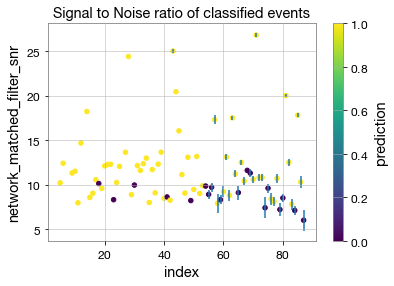

In [214]:
y = "network_matched_filter_snr"
yerr = xcatalog[[f"{y}_lower", f"{y}_upper"]]
yerr = yerr.to_numpy().T

xcatalog.plot.scatter(
  x="index",
  y=y,
  c="prediction",
  yerr=yerr,
  title="Signal to Noise ratio of classified events",
  colormap='viridis'); pass

plt.savefig(conf.SCREENSHOTS_DIR / "snr_pred.jpg")

Clearly, most of the errors of our classifier are events with SNR <= 11.

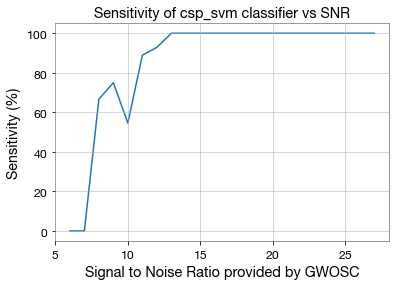

In [284]:
df = xcatalog[["network_matched_filter_snr", "prediction"]].dropna()
df["snr"] = df["network_matched_filter_snr"].apply(lambda x: round(x, 0))
del df["network_matched_filter_snr"]

ratios = {}
for snr, rows in df.groupby("snr"):
  ratios[snr] = 100 * sum(rows["prediction"]) / len(rows["prediction"])

plt.plot(ratios.keys(), ratios.values())
plt.title("Sensitivity of csp_svm classifier vs SNR")
plt.ylabel("Sensitivity (%)")
plt.xlabel("Signal to Noise Ratio provided by GWOSC")
plt.savefig(conf.SCREENSHOTS_DIR / "sensitivity-snr.jpg")
pass

### Mass ratios

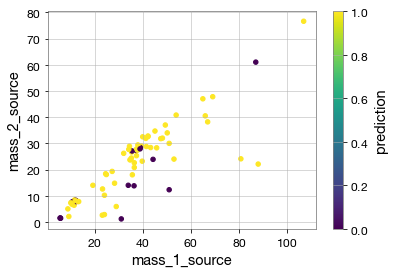

In [228]:
x = "mass_1_source"
y = "mass_2_source"

xcatalog.plot.scatter(
  x=x,
  y=y,
  c="prediction",
  colormap='viridis'); pass

plt.rcParams['errorbar.capsize']=1